若不禁用 quoting 则 pandas 将读取 1,225,088 行，其中一部分数据行被双引号打乱

认为 1,229,618 是正确的数据总行数

In [2]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

col_names_train = ['uid', 'mid', 'time', 'forward_count', 'comment_count', 'like_count', 'content']
col_names_predict = ['uid', 'mid', 'time', 'content']
output_columns = ['like_count', 'forward_count', 'comment_count']

train_raw_df = pd.read_table('./data/raw/weibo_train_data.txt', 
                             names=col_names_train, 
                             quotechar=None, quoting=csv.QUOTE_NONE)
test_raw_df = pd.read_table('./data/raw/weibo_predict_data.txt', 
                            names=col_names_predict, 
                            quotechar=None, quoting=csv.QUOTE_NONE)

# def count_log_scale(df: pd.DataFrame):
#     for col in output_columns:
#         df[col] = df[col].map(lambda x: np.log(x + 1))
# count_log_scale(train_raw_df)
train_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229618 entries, 0 to 1229617
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   uid            1229618 non-null  object
 1   mid            1229618 non-null  object
 2   time           1229618 non-null  object
 3   forward_count  1229618 non-null  int64 
 4   comment_count  1229618 non-null  int64 
 5   like_count     1229618 non-null  int64 
 6   content        1229616 non-null  object
dtypes: int64(3), object(4)
memory usage: 65.7+ MB


In [2]:
print('num of unique users:', len(train_raw_df['uid'].unique()))
print('num of posts:', len(train_raw_df['mid'].unique()))

num of unique users: 37263
num of posts: 1229618


In [3]:
df = train_raw_df
def sum_interaction(row):
    return (row['forward_count'] + row['comment_count'] + row['like_count'])

non_zero_posts = df[df.apply(sum_interaction, axis=1) != 0]
len(non_zero_posts) / len(df)

0.3571800347750277

统计文本长度分布

73.17218274293317 46.55578637372513


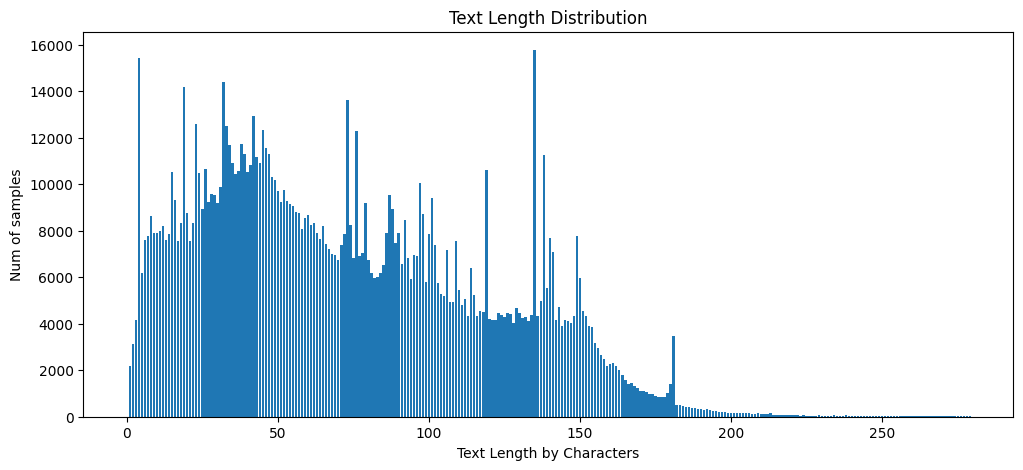

In [4]:
text_length = train_raw_df['content'].astype(str).apply(len).to_numpy()
print(np.mean(text_length), np.std(text_length))

fig = plt.figure(figsize=(12,5))
plt.hist(text_length, bins=range(0, text_length.max() + 1), align='left', rwidth=0.8)
plt.xlabel('Text Length by Characters')
plt.ylabel('Num of samples')
plt.title('Text Length Distribution')
plt.show()

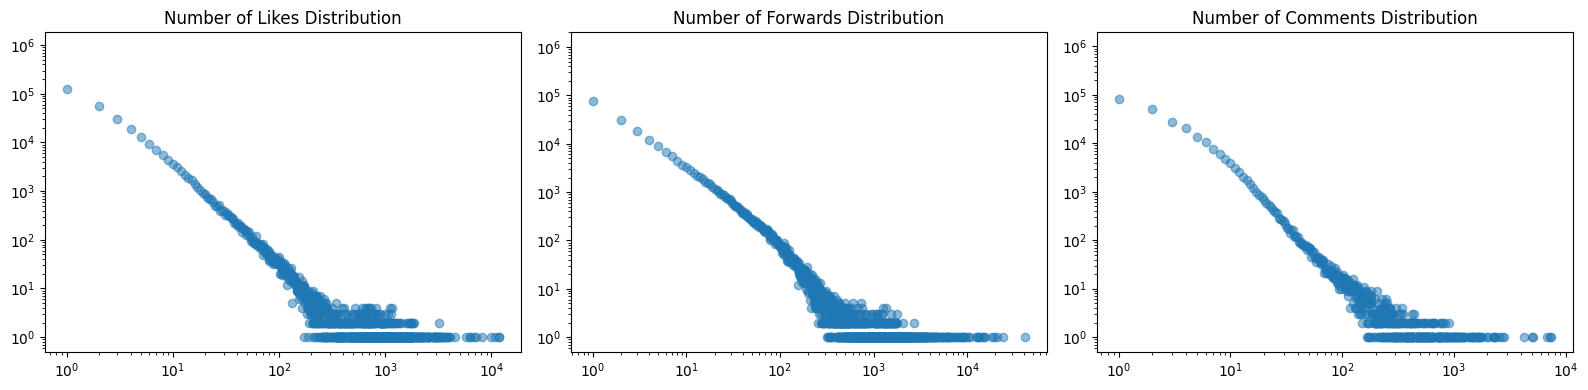

In [5]:
like_count = train_raw_df['like_count'].value_counts()
forward_count = train_raw_df['forward_count'].value_counts()
comment_count = train_raw_df['comment_count'].value_counts()

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
# plt.scatter(like_count.index, like_count.values, color='skyblue')

axs[0].scatter(like_count.index, like_count.values, alpha=0.5)
axs[0].set_title('Number of Likes Distribution')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].scatter(forward_count.index, forward_count.values, alpha=0.5)
axs[1].set_title('Number of Forwards Distribution')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[2].scatter(comment_count.index, comment_count.values, alpha=0.5)
axs[2].set_title('Number of Comments Distribution')
axs[2].set_xscale('log')
axs[2].set_yscale('log')

plt.tight_layout()
# plt.title('Distribution of Likes/Forwards/Comments')
plt.show()

In [ ]:
like_count.values

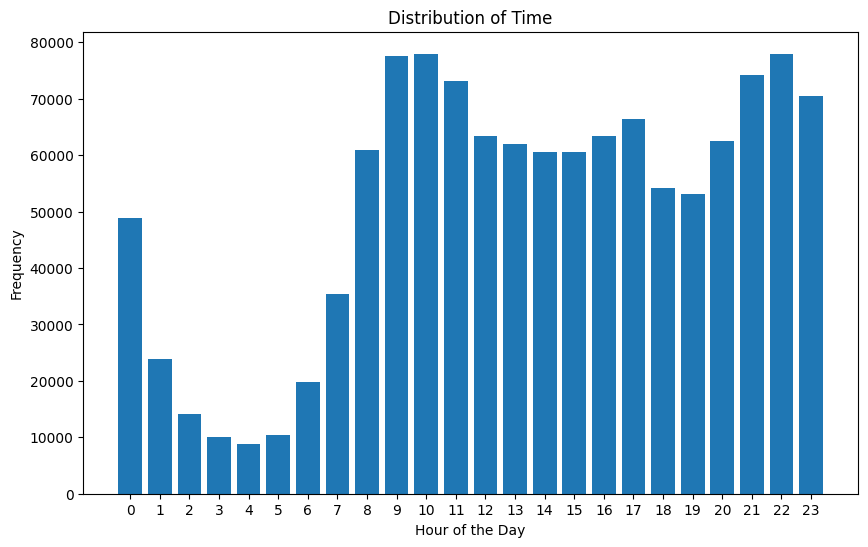

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap plot of the correlation matrix
corr_matrix = train_raw_df[output_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.title("Correlation Matrix")
plt.show()

In [ ]:

hours = pd.to_datetime(train_raw_df['time']).dt.hour
plt.figure(figsize=(10, 6))
# plt.hist(hours, bins=24, color='skyblue', edgecolor='black')
plt.bar(hours.value_counts().index, hours.value_counts().values)

# Set labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.title('Distribution of Time')

plt.xticks(range(0, 24))
plt.show()

100%|██████████| 1229618/1229618 [00:30<00:00, 40648.98it/s]


<Figure size 1000x600 with 0 Axes>

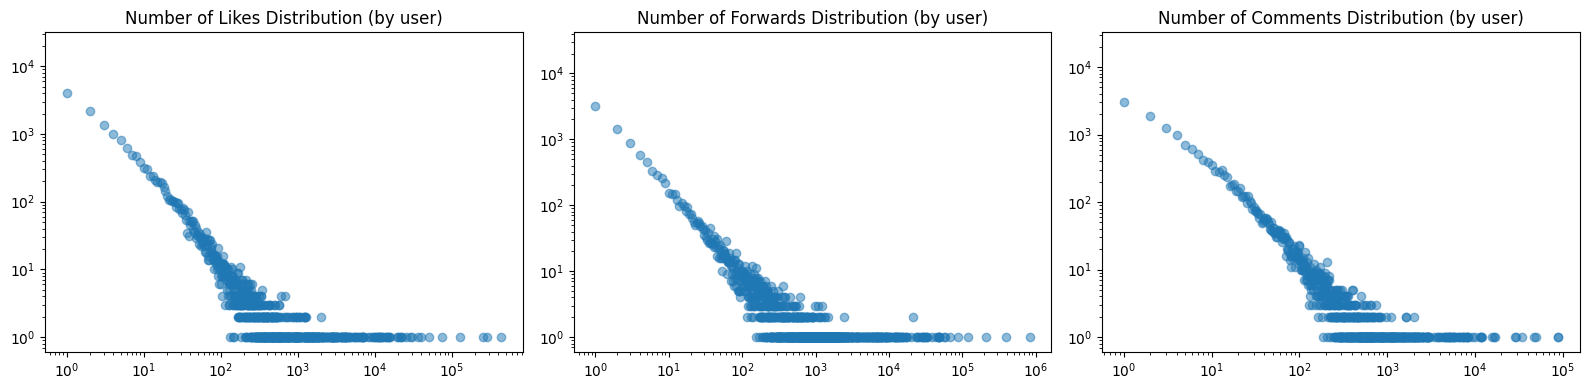

In [7]:
from collections import Counter
from tqdm import tqdm
all_users = train_raw_df['uid'].unique()

# 累加每个用户的所有博文获得的点赞/转发/评论
user_total_likes = {u: 0 for u in all_users}
user_total_forwards = {u: 0 for u in all_users}
user_total_comments = {u: 0 for u in all_users}
for index, row in tqdm(train_raw_df.iterrows(), total=len(train_raw_df)):
    user_total_likes[row['uid']] = user_total_likes[row['uid']] + int(row['like_count'])
    user_total_forwards[row['uid']] = user_total_forwards[row['uid']] + int(row['forward_count'])
    user_total_comments[row['uid']] = user_total_comments[row['uid']] + int(row['comment_count'])


user_likes_counter = Counter(user_total_likes.values())
user_forwards_counter = Counter(user_total_forwards.values())
user_comments_counter = Counter(user_total_comments.values())

plt.figure(figsize=(10, 6))
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

axs[0].scatter(user_likes_counter.keys(), user_likes_counter.values(), alpha=0.5)
axs[0].set_title('Number of Likes Distribution (by user)')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].scatter(user_forwards_counter.keys(), user_forwards_counter.values(), alpha=0.5)
axs[1].set_title('Number of Forwards Distribution (by user)')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[2].scatter(user_comments_counter.keys(), user_comments_counter.values(), alpha=0.5)
axs[2].set_title('Number of Comments Distribution (by user)')
axs[2].set_xscale('log')
axs[2].set_yscale('log')

plt.tight_layout()
# plt.title('Distribution of Likes/Forwards/Comments')
plt.show()

提取每个用户的DataFrame，确保数据按时间排序

In [3]:
df = train_raw_df
user_dataframes_sorted = {uid: group.sort_values(by='time') for uid, group in df.groupby('uid')}

count
31116    0.000027
17231    0.000054
12059    0.000081
7906     0.000107
7830     0.000134
           ...   
5        0.642917
4        0.705043
3        0.782573
2        0.875721
1        1.000000
Name: count, Length: 640, dtype: float64


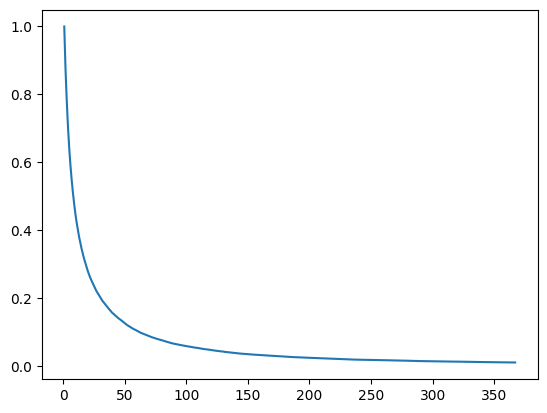

In [17]:
# 字典 发帖数量为 k 的用户数量
num_posts_of_users = df['uid'].value_counts().value_counts()
with open('./test_data.json', 'w') as f:
    f.write(str([num_posts_of_users.index.tolist(), num_posts_of_users.values.tolist()]))

# 发帖数量大于 k 的用户数量占比
# 累积数据操作: 
# 首先按自变量排序 需要实现大于 k 的累积 则为降序
cumulative_num_posts = num_posts_of_users.sort_index(ascending=False).cumsum()
# 累积完成后 对 y 数据归一化为百分比
cumulative_num_posts = cumulative_num_posts / cumulative_num_posts.max()
print(cumulative_num_posts)

plt.plot(cumulative_num_posts[cumulative_num_posts > 0.01].index, cumulative_num_posts[cumulative_num_posts > 0.01].values)
plt.show()

In [ ]:
# 测试
example_df_sorted = user_dataframes_sorted["4ac74188244820225e905a3cf93a83f5"]

# example_df_sorted
for uid, df_user in user_dataframes_sorted.items():
    filename = f"data/user/{uid}.csv"  # 创建文件名，以用户ID为标识
    df_user.to_csv(filename, index=False)  # 保存DataFrame到CSV文件，不包含索引
    print(f"Saved: {filename}")  # 打印保存信息作为确认

# user_time_grouped.tocsv('data/user_time_grouped.csv', index=False)

In [17]:

# # 统计每个like数目下博文的数量
# like_count_distribution = train_raw_df['like_count'].value_counts().sort_index()
# 
# # print(like_count_distribution)
# # 可视化
# plt.figure(figsize=(10, 6))
# plt.bar(like_count_distribution.index, like_count_distribution.values)
# plt.title('Post Count by Like Count')
# plt.xlabel('Like Count')
# plt.ylabel('Post Count')
# plt.show()

# comment_count_distribution = train_raw_df['comment_count'].value_counts().sort_index()
# plt.bar(comment_count_distribution.index, comment_count_distribution.values)
# plt.title('Post Count by comment Count')
# plt.xlabel('comment Count')
# plt.ylabel('Post Count')
# plt.show()

查看训练集和测试集中 uid 的重叠情况

In [10]:
users_train = train_raw_df['uid'].unique()
users_test = test_raw_df['uid'].unique()

print('train:', len(set(users_train)))
print('test:', len(set(users_test)))
print(len(set.intersection(set(users_test), set(users_train))))
print('测试集中 未在训练集中出现的 uid 数量', len(set.difference(set(users_test), set(users_train))))

train: 37263
test: 17550
16853
测试集中 未在训练集中出现的 uid 数量 697


Time Span

In [11]:
all_datetimes = pd.to_datetime(train_raw_df['time'])
print( all_datetimes.min(), all_datetimes.max() )
valid = all_datetimes[all_datetimes > pd.to_datetime('2015-07-01 00:00:00')]

print( valid.min(), valid.max() )

2015-02-01 00:00:03 2015-07-31 23:59:55
2015-07-01 00:00:01 2015-07-31 23:59:55


## Corelation

In [ ]:
from preprocess import load_dataset, extract_targets

data = load_dataset()
targets_train = extract_targets(data['train'], 'linear')

targets_train.shape


In [ ]:
from matplotlib import pyplot as plt
import numpy as np

point_size = np.log((targets_train[:,0] + targets_train[:,1] + targets_train[:,2]) + 1) * 5
alphas = np.where(point_size/100 > 1.0, 1.0, point_size/100)
print(point_size.shape)

plt.figure(figsize=(10, 6))
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].scatter(targets_train[:,0], targets_train[:,1], s=point_size, alpha=alphas)
axs[0].set_title('#Likes vs #Forwards')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].scatter(targets_train[:,0], targets_train[:,2], s=point_size, alpha=alphas)
axs[1].set_title('#Likes vs #Comments')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

plt.tight_layout()
# plt.title('Distribution of Likes/Forwards/Comments')
plt.show()